Advances in imaging equipment and automation have led to an overabundance of data on the functioning of the brain. Technologies today can sample brain activity from a large number of neurons in a large region while organisms are actively behaving. For example, by simultaneously recording the electrical activity of every neuron of the mouse brain over an extended period of time, the amount of data generated will create completely new paradigms for biology, that will require the development of tools to extract value from such unprecedented amount of information.

In this Notebook, we use PySpark and the [Thunder project](https://github.com/thunder-project/thunder), which is developed on top of PySpark, for processing large amounts of time series data in general, and neuroimaging data in particular. We will use these tools for the task of understanding some of the structure of Zebrafish brains, which is a typical (and simple) example used in Neuroimaging. Using Thunder, we will cluster different regions of the brain (representing groups of neurons) to discover patterns of activity as the zebrafish behaves over time.

**Note**: Please, use the documentation for the [Thunder API](http://docs.thunder-project.org/) to learn the details of function calls!


# Goals

The main goals of this notebook are:

1. Learn about Thunder and how to use it
2. Revisit the K-Means algorithm and the method for choosing K
3. Learn alternative approaches to improve the results


# Steps
1. In section 1, we go though some background concepts that are used in this notebook.
2. Next, in section 2, we will get familiar with Thunder, its methods and its data types, by working on some simple tasks.
3. Finally, in section 3, we will build a model to cluster the neurons of a zebrafish based on their behavior. In this step, we will learn about how to use K-Means when the value of K is unknown. Finally, some tricks to improve the results are introduced.

# 2. Let's play

Well, wait a second before we play... Remember, we're going to use Spark to perform some of the computations related to this Notebook. Now, when you spin a Zoe Notebook application (this comment is valid for students at Eurecom), you'll gain access to an individual, small Spark cluster that is dedicated to your Notebook. This cluster has two worker machines, each with 6 cores. As such, a good idea to obtain smooth performance and a balanced load on the workers, is to ```repartition``` your data (i.e., the RDDs you use to represent images or time series).

In this Notebook we **expect** students to take care of repartitioning, and such care will be compensated by bonus points.

# 1. Background concepts

In this section, we cover the terminology and the concepts that constitute the domain knowledge for this notebook.

As it should be well-known, a `pixel` is a combination of "**pic**ture **el**ement": digital images can be modeled as simple 2-dimensional (2D) matrices of intensity values, and each element in the matrix is a pixel. In color images, a pixel contains values of red, green, and blue channels. In a grayscale image, the three channels have the same value, such that each pixel is reduced to be a single value.

A single 2D image is not nearly enough to express 3D objects, which use a **voxel**, representing a value of the 3D image on a regular grid in a three-dimensional space.  A possible technique to work on 3D images is to acquire multiple 2D images of different slices (or `planes`, or `layers`) of a 3D object, and stack them one on top of each other (a z-stack). This ultimately produces a 3D matrix of intensity values, where each value represents a `volume element` or `voxel`.

![](https://upload.wikimedia.org/wikipedia/commons/b/b4/Voxelgitter.png)
<div style="text-align:center;">This z-stack image has 4 layers. A point is a voxel. It can be determined by the layer's index and the position in that layer.</div>

In the context of the Thunder package, we use term `image` for `3D-image` or `stack image`. Thunder uses `Image` type to  represent 3D-image. Each `Image` object is a collection of either 2D images or 3D volumes. In practice, it wraps an n-dimensional array, and supports either distributed operations via Spark or local operations via  numpy , with an identical API.

Stack-images can represent 3D objects, but it can be difficult to take the temporal relationship of the images into account. To do that, we need another data structure that shows the changes of voxels over time. In the Thunder package, the internal `Series` type can be used exactly for this purpose. Each `Series` is a 1D array such that each element is a value of the voxel at a timestamp.

The most common series data is time series data, in which case the index is time and each record is a different signal, like a channel or pixel.

We now have sufficient material to start playing with Thunder !!!

## 2.1. Play with Image objects

### a. Loading image data

Both `images` and `series` can be loaded from a variety of data types and locations. You need to specify whether data should be loaded in 'local' mode, which is backed by a numpy array, or in 'spark' mode, which is backed by an RDD by using the optional argument `engine`. The argument `engine` can be either `None` for local use or a SparkContext for` distributed use with Spark.

```python
import thunder as td

# load data from tif images
data = td.images.fromtif('/path/to/tifs')

# load data from numpy-arrays
data = td.series.fromarray(somearray)
data_distributed = ts.series.fromarray(somearray, engine=sc)
```

We can load some example image data by:

In [2]:
%matplotlib inline
import thunder as td
import numpy as np
import seaborn as sns
sns.set_style('darkgrid')
sns.set_context('notebook')

# load some example image data
image_data = td.images.fromexample('fish', engine=sc)

# print the number of images
print(image_data.count())

20


### b. Inspecting image data

Shape of the data: (20, 2, 76, 87)
Shape of the data of the first image: (2, 76, 87)
Data of the first image: [[[26 26 26 ..., 26 26 26]
  [26 26 26 ..., 26 26 26]
  [26 26 26 ..., 27 27 26]
  ..., 
  [26 26 26 ..., 27 27 26]
  [26 26 26 ..., 27 26 26]
  [25 25 25 ..., 26 26 26]]

 [[25 25 25 ..., 26 26 26]
  [25 25 25 ..., 26 26 26]
  [26 26 26 ..., 26 26 26]
  ..., 
  [26 26 26 ..., 26 26 26]
  [26 26 26 ..., 26 26 26]
  [25 25 25 ..., 26 26 26]]]


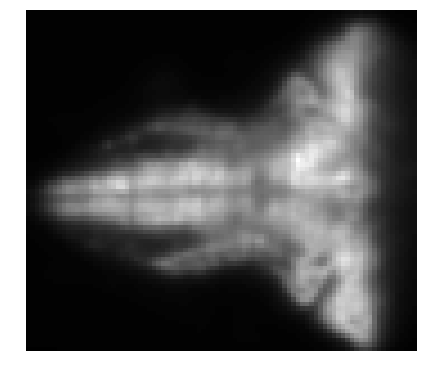

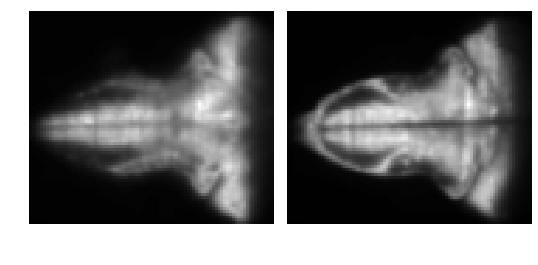

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt

# import two function to draw images easier
from showit import image as draw_image
from showit import tile as draw_tile

print("Shape of the data:", image_data.shape)

first_image = image_data.first() # get the values of Image object
# or first_image = image_data[0] # get the Image object

print("Shape of the data of the first image:", first_image.shape)

print("Data of the first image:", first_image)


# draw the first layer of the first image
draw_image(first_image[0])

# draw all layers of the first image
draw_tile(first_image)

# we can use index slices to take images
samples = image_data[0:6]


From the result above, the shape of the loaded data is (20, 2, 76, 87). It means we have total 20  3D images objects. Each image has 2 layers, each layer has size 76x87. 

Note that, although  data  is not itself an array (it can be a kind of RDD), we can index into it using bracket notation, and pass it as input to plotting methods that expect arrays. In these cases, the data will be automatically converted.

One of the advantages of working in Python is that we can easily visualize our data stored into Spark RDDs using the Matplotlib library. Function `draw_image` and `draw_tile` that take advantages of Matplotlib are examples.

![](https://farm2.staticflickr.com/1604/24934700445_833f0a5649_t.jpg)

#### Question 1

<div class="alert alert-info">  
a) Use the function `imgshow` from matplotlib to plot each layer of the first image in `image_data`.  

b) Discuss the choice of parameters you use for the method `imgshow`  

</div>

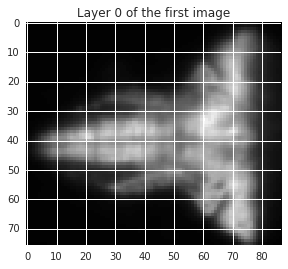

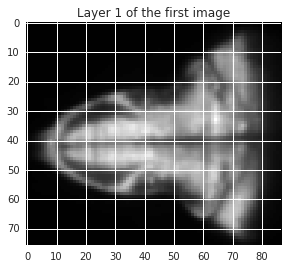

In [4]:

img = image_data.first() 
# or:
# img = image_data[1]


# show the first layer
plt.imshow(img[0], interpolation='nearest', aspect='equal', cmap='gray')
plt.title("Layer 0 of the first image")
plt.show()

# show the second layer
plt.imshow(img[1], interpolation='nearest', aspect='equal', cmap='gray')
plt.title("Layer 1 of the first image")
plt.show()


Then, we can perform operations that aggregate information across images.

![](https://farm2.staticflickr.com/1604/24934700445_833f0a5649_t.jpg)

#### Question 2
<div class="alert alert-info">

Calculate the standard deviation across all images you have in `image_data` (that is, our dataset). To clarify, let's focus on an individual layer (say the first layer of each image). For every `voxel`, compute the standard deviation of its values across different images for the same layer. Visualize the standard deviation you obtain, for example concerning a single layer (as before, say the first layer).

</div>

<div class="label label-success">HINT 1</div> to avoid wasting time and energy, make sure you lookup for methods that could help answer the question from the Thunder documentation.  

<div class="label label-success">HINT 2</div> We can also use function `draw_image(<data>)` to plot an image in a simple way instead of using many statements with matplotlib as before.

<div class="label label-danger">NOTE</div> Comment the image you obtain. What does it mean to display the standard deviation across all images in a single layer?

standard deviation of the first layer of the images:


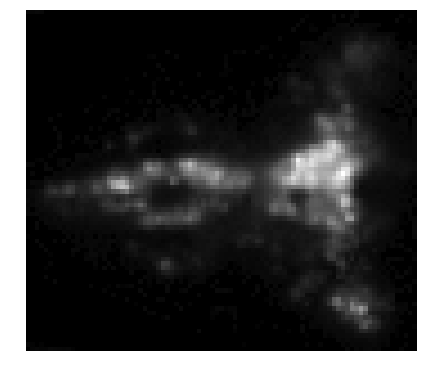

In [5]:

####!@SOLUTION@!####
# calculate standard deviation of images
std_imgs = image_data.std()
print('standard deviation of the first layer of the images:')
draw_image(std_imgs[0,0])


<div class="alert alert-warning">

Here we obtained the 2D image for the standart deviation of the first layer of the images. The more white a pixel is, the bigger it changes over time.

</div>

### c. Selecting samples of image data

The Images API offers useful methods for working with large image data. For example, in some cases it is necessary to subsample each image, to make sure we can analyze it efficiently.

![](https://farm2.staticflickr.com/1604/24934700445_833f0a5649_t.jpg)

#### Question 3

<div class="alert alert-info">  
The source code below subsamples image data with different ratios on different dimensions.   

a) Complete the source code to plot the first layer of the first image.   

b) What is the shape of `image_data` before and after subsampling?  

</div>

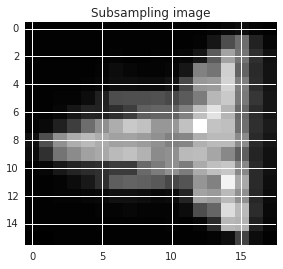

Before subsampling: Images
mode: spark
dtype: uint8
shape: (20, 2, 76, 87)
After subsampling: Images
mode: spark
dtype: uint8
shape: (20, 2, 16, 18)


In [6]:

subsampled = image_data.subsample((1, 5, 5))
# Stride to use in subsampling. If a single int is passed, each dimension of the image
# will be downsampled by this same factor. If a tuple is passed, it must have the same
# dimensionality of the image. The strides given in a passed tuple will be applied to
# each image dimension
plt.imshow(subsampled.first()[0], interpolation='nearest', aspect='equal', cmap='gray') 
plt.title("Subsampling image")
plt.show()
print("Before subsampling:", image_data)
print("After subsampling:", subsampled)


<div class="alert alert-warning">
The "subsample" method of image datatype reduces the dimension by the factor in the tuple
</div>

Note that `subsample` is an RDD operation, so it returns immediately. Indeed, we know that in Spark you must apply a RDD action to trigger the actual computation.

### d. Converting image data
We can also convert an RDD of images to a RDD of series by:

In [7]:
seriesRDD = image_data.toseries()
seriesRDD.cache()

Series
mode: spark
dtype: uint8
shape: (2, 76, 87, 20)

![](https://farm2.staticflickr.com/1604/24934700445_833f0a5649_t.jpg)

#### Question 4
<div class="alert alert-info">
According to your understanding about `Series` objects which was introduced in section 1, what is the shape of `seriesRDD` and its elments ?  

Comment your results, don't just display numbers.
</div>

<div class="alert alert-warning">
The shape of `seriesRDD` is (2, 76, 87, 20), which is a list of 13224 (2 x 76 x 87) elements, and each element is a array of 20 values, which is the value of each pixel over time. <br/>
For the `image_data` variable, this is a collection of 20 3d-images, each image has dimension (2 x 76 x 87). However, for the `seriesRDD`, we consider each value point is a time series of 20 values.
</div>

<div class="answer">

PUT YOUR ANSWER HERE !!!  
  
To take temporal relationship of the images into account.  
Series show the changes of voxels over time.  
Series is a 1D array such that each element is a value of the voxel at a timestamp.  

</div>

For a large data set that will be analyzed repeatedly as a `Series`, it will ultimately be faster and more convienient to save `Images` data to a collection of flat binary files on a distributed file system, which can in turn be read back in directly as a `Series`, rather than repeatedly converting the images to a `Series` object. This can be performed either through a ThunderContext method, `convertImagesToSeries`, or directly on an Images object, as done below:

In [8]:
# image_data.toseries().tobinary('directory', overwrite=True)
#ts = td.series.frombinary('directory', engine=sc)

We will study about `Series` object in the next section.

## 2.2. Play with Serises objects

### a. Loading Series data

In this section, we use a sample data to explore `Series` objects.

In [9]:
# series_data = td.series.fromexample('fish', engine=sc)
# series_data = td.series.frombinary(path='s3n://thunder-sample-data/series/fish', engine=sc)
series_data = image_data.toseries()

### b. Inspecting Series data

`Series_data` is a distributed collection of key-value records, each containing a coordinate identifier and the time series of a single `voxel`. We can look at the first record by using `first()`. It’s a key-value pair, where the key is a tuple of `int` (representing a spatial coordinate within the imaging volume) and the value is an one-dimensional array.

In [10]:
first_series = series_data.first() # get the values of Series object
#first_series = series_data[0] # get a Series object

print("Shape of series:", series_data.shape)
print("The first series:", first_series)
print("Each element in series has", len(first_series), "values")

# print the 10th value of voxel (0,0,0)
# layer = 0
# coordinator = (0,0) in that layer
print("value 10th of voxel (0,0,0):", np.array(series_data[0,0,0,10]))

Shape of series: (2, 76, 87, 20)
The first series: [26 26 26 26 26 26 26 25 26 25 25 25 26 26 26 26 26 26 26 26]
Each element in series has 20 values
value 10th of voxel (0,0,0): 25


The loaded series data is a multi-dimensional array. We can access the values of a voxel in time series by using a tuple as above. In our data, each voxel has 20 values corresponding to 20 states at 20 different times.

### c. Selecting Series data
Series objects have a 1D index, which can be used to subselect values.

In [11]:
print("shape of index:", series_data.index.shape)
print("the first element of a subset", series_data.between(0,8).first())

shape of index: (20,)
the first element of a subset [26 26 26 26 26 26 26 25]


Values can be selected based on their index:

In [12]:
print(series_data.select(lambda x: x > 3 and x < 8).index) #timestamp = 4,5,6,7
print(series_data.select(lambda x: x > 3 and x < 8).first()) #values for the first voxel


[4, 5, 6, 7]
[26 26 26 25]


![](https://farm2.staticflickr.com/1604/24934700445_833f0a5649_t.jpg)

#### Question 5
<div class="alert alert-info">

Plot the first 20 values of **all** series objects (that is the values of a voxel) in the series data. This means, on the same plot, you should visualize the values each voxel takes in the first 20 time intervals.

</div>

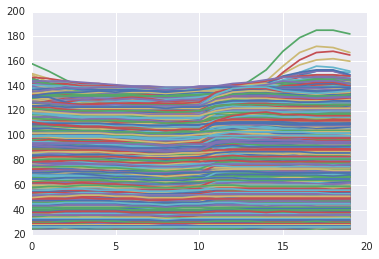

In [13]:

import numpy as np

# only select the first 20 states of each object
samples = series_data.between(0,20).tordd().values().collect()

plt.plot(np.array(samples).T)
plt.show()


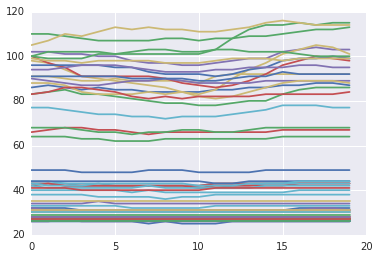

In [14]:
subsampled_series = image_data.subsample((2, 10, 10)).toseries()

samples = subsampled_series.between(0,20).tordd().values().collect()

plt.plot(np.array(samples).T)
plt.show()

Now, another objective we can have is to select specific series objects within the same series data. For example, we can select objects randomly by using function `sample`.

![](https://farm2.staticflickr.com/1604/24934700445_833f0a5649_t.jpg)

#### Question 6

<div class="alert alert-info">

Let's plot a random subset of the data using the method `sample`.  

Complete the source code below to plot the first 20 values of 30 objects that are selected randomly among those that pass the condition on the standard deviation, using function `sample`.

</div>

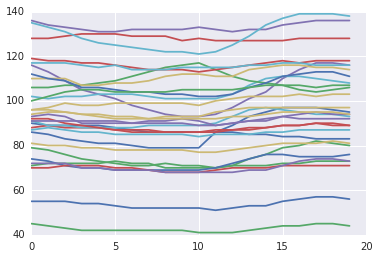

In [15]:

# select 30 objects randomly which have standard deviation > threshold
# Extract random subset of records, filtering on a summary statistic.
examples = series_data.filter(lambda x: x.std() > 1.0).sample(30)
# only plot first 20 states of each object
plt.plot(np.array(examples).T)
plt.show()


### d. Preprocessing Series data
A `Series` objects has some methods which can be useful in an eventual preprocessing phase.

For example,`center` subtracts the mean, `normalize` subtracts and divides by a baseline (either the mean, or a percentile).

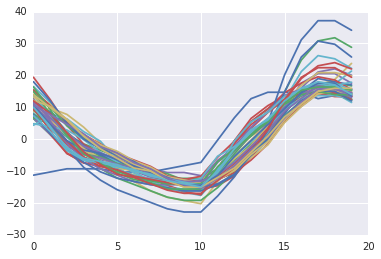

In [16]:
examples = series_data.center().filter(lambda x: x.std() >= 10).sample(50)
plt.plot(np.array(examples).T)
plt.show()

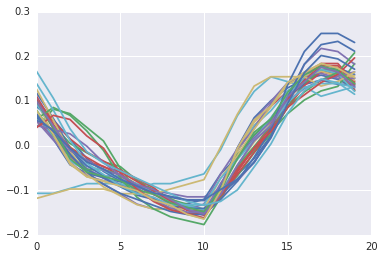

In [17]:
normalizedRDD = series_data.normalize(method='mean').filter(lambda x: x.std() >= 0.1).sample(50)
plt.plot(np.array(normalizedRDD).T)
plt.show()

### e. Computing statistics about Series data
A `Series` can be summarized with statistics both within and across images. To summarize **across records** (the statistic of all voxels at each timestamp), we can do the following:

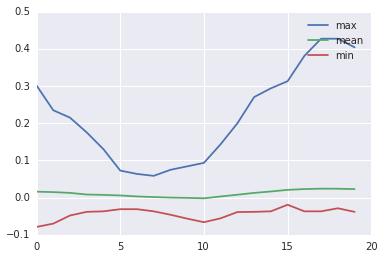

In [18]:
plt.plot(series_data.normalize().max(), label='max');
plt.plot(series_data.normalize().mean(), label='mean');
plt.plot(series_data.normalize().min(), label='min');
plt.legend()

To summarize **within records**, we can use the `map` method:

In [19]:
means = series_data.map(lambda x: x.mean())
flat_means = means.flatten().toarray()
flat_stdevs = stdevs = series_data.map(lambda x: x.std()).flatten().toarray()

print("means:", flat_means)
print("length of means:", len(flat_means))
print("mean of the first series:", flat_means[0])
print("standard deviation of the first series:", flat_stdevs[0])

means: [ 25.8   25.85  25.7  ...,  26.    26.    26.  ]
length of means: 13224
mean of the first series: 25.8
standard deviation of the first series: 0.4


`means` is now a `Series` object, where the value of each record is the mean across the time series for that voxel.

Note that in the source code above, we use function `toarray` to return all records to the driver as a numpy array.

For this `Series`, since the keys correspond to spatial coordinates, we can `pack` the results back into a local array in **driver node**.


To look at this array as an image, we can use function `draw_image` as before.

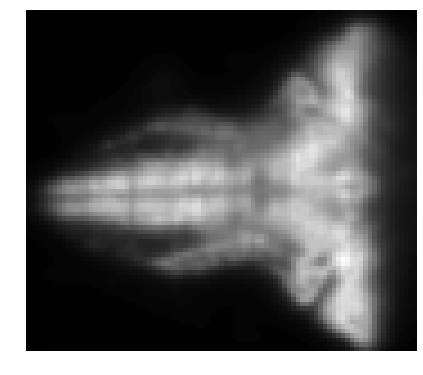

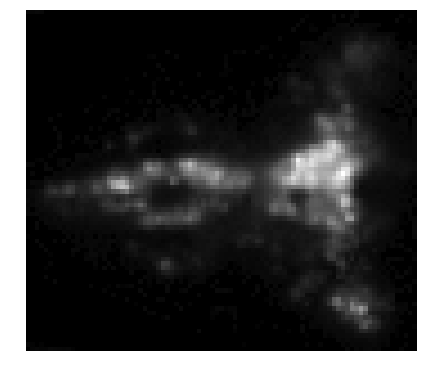

In [20]:
# we should recover the shape of means before plotting
# draw the stdandard deviations of series that belong to the first layer
draw_image(flat_means.reshape((2, 76, 87)) [0,:,:])
draw_image(flat_stdevs.reshape((2, 76, 87)) [0,:,:])

Note that `toarray` is an example of a local operation, meaning that all the data involved will be sent to the Spark driver node. In this case, packing the mean is no problem because its size is quite small. But for larger data sets, this can be **very problematic**. So, it's a good idea to downsample, subselect, or otherwise reduce the size of your data before attempting to pack large image data sets! 

### f. Identifying correlations

In several problem domains, it may also be beneficial to assess the similarity between a designated signal (time series) and another signal of interest by measuring their correlation. For example, say we have two time series corresponding to the consumption of Coca Cola and Pepsi, it would perhaps be interesting to verify whether behavioural patterns are similar for both brands over time.<br>

Simply as a proof of concept, we shall compare our data to a random signal and we expect that, for a random signal, the correlation should be low. The signal can be stored as a numpy array or a MAT file containing the signal as a variable. Note that the size of the signal must be equal to the size of each `Series` element.

In [21]:
from numpy import random
signal = random.randn(len(first_series))
print("The correlation of the first element with random signal:" , series_data.correlate(signal).first())

first_element = series_data.first()
corr = series_data.correlate(np.array(first_element)).first()
print("The correlation of the first element with itselft:", corr)

The correlation of the first element with random signal: [-0.12770261]
The correlation of the first element with itselft: [ 1.]


# 3. Usecase

## 3.1. Context
Neurons have a variety of biochemical and anatomical properties. Classification methods are thus needed for clarification of the functions of neural circuits as well as for regenerative medicine. In this usecase, we want to categorize the neurons in a fish brain, based on their behavior. The behavior of a neuron can be expressed by the change of its states. The activies of the brains are captured over time into images.

Neurons have a variety of biochemical and anatomical properties. Classification methods are thus needed for clarification of the functions of neural circuits as well as for regenerative medicine. In this usecase, we want to categorize the neurons in a fish brain, based on their behavior. The behavior of a neuron can be expressed by the change of its states. The activies of the brains are captured over time into images.

In this notebook,  we use K-Means, a well known clustering algorithm which is also familiar to you, as it was introduced during the last lecture on anomaly detection.

## 3.2 Data
The dataset we will use is the time series data which we played with in the previous section. Refer to section 2 if you want to duplicate the code to load such data.

## 3.3.  Building model
### a. Importing required modules

In [22]:
%matplotlib inline
import matplotlib.pyplot as plt
from pyspark.mllib.clustering import KMeans, KMeansModel
from matplotlib.colors import ListedColormap

import thunder as td
import numpy as np

### b. Loading & inspecting the data

![](https://farm2.staticflickr.com/1604/24934700445_833f0a5649_t.jpg)

#### Question 7
<div class="alert alert-info">

Load example series data from `fish`, then normalize and cache it to speed up repeated queries. Print the dimensional information of the loaded data.

</div>

In [23]:
####!@SOLUTION@!####
# we must normalize it to get best clustering
data = td.images.fromexample('fish', engine=sc).toseries().normalize()

# cache it to speed up related queries
data.cache()

# check the dimensions of data
print(data.shape)


(2, 76, 87, 20)


![](https://farm2.staticflickr.com/1604/24934700445_833f0a5649_t.jpg)

#### Question 8
<div class="alert alert-info">
When studying the properties of large data set, we often take a small fraction of it. We have many strategies to select this subset, such as selecting randomly, selecting elements that has the standard deviation bigger than a threshold, or mixing the conditions.  

In this notebook, we will use the second method as a small demonstration.

<ul></ul>

In order to choose a good value for the threshold of standard deviation, we should compute the stddev of each series and plot a histogram of a 10% sample of the values.

<ul></ul>

Complete the source code below to compute the standard deviation of series in data. Plot the histogram of it and discuss it in details. In your opinion, what should be the best value for the threshold ?

</div>

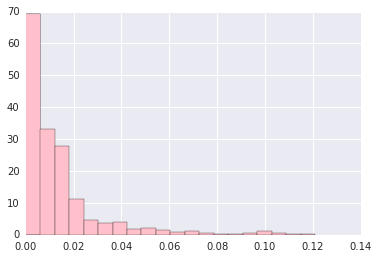

In [24]:
# calculate the standard deviation of each series
# then select randomly 10% of value to plot the histogram

stddevs = (data
           .map(lambda x: x.std())
           .sample(int(0.1*data.count()))
           .toarray()
          )

# plot the histogram of 20 bins
plt.hist(stddevs, bins=20, normed=True, color='pink')
plt.show()



<div class="alert alert-warning">

In our opinion, the best value for the threshole should be around 0.04 to 0.08. If we choose a smaller value (ex: 0.01 or 0.02), the value of voxel does not change over time. If we choose a larger value (ex: 0.1), the remaining value might be too little.

</div>

![](https://farm2.staticflickr.com/1604/24934700445_833f0a5649_t.jpg)

#### Question 9

<div class="alert alert-info">

Extract some samples just to look at the typical structure of the time series data.
The objects are selected randomly, and has the standard deviation bigger than the threshold which you picked in question 8.
Plot the samples and discuss your obtained figure.

</div>

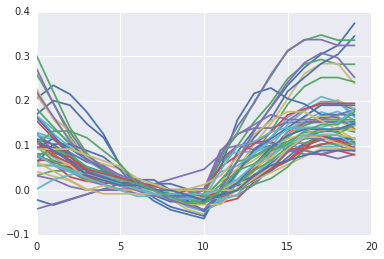

In [25]:
# sample 50 objects of the data randomly base on the standard deviation
threshold = 0.04

examples = (data
           .filter(lambda x: x.std() >= threshold)
           .sample(50)
           .toarray()
          )

# plot the sample data
plt.plot(examples.T)
plt.show()


<div class="alert alert-warning">
Most of the filtered data have the same pattern (decrease -> increase -> slightly descrease).
</div>

### c. Clustering series
In this section, we will use K-means to cluster the series. In other words, we cluster the voxels based on the their behavior. Currently, we have no clue about how many groups `K` of neural behavior. To this end, instead of choosing a single value K, we use multiple values, build model with each `K` and compare the resulting error values. After that, we can choose the best value of `K`. 

![](https://farm2.staticflickr.com/1604/24934700445_833f0a5649_t.jpg)

#### Question 10

<div class="alert alert-info">

Complete the source below to build multiple models coresponding to multiple values of `K` using algorithm KMeans of Thunder.  

a) Comment the structure of the code. Precisely, focus on the `for` loop, and state what is parallel and what is not.  

b) Can you modify the structure of the code such that you use the most of the parallelization capabilities of Spark?  

</div>

In [26]:
import time

#%%timeit -n1 -r1

t0 = time.time()

# declare the possible values of K
ks = [5, 10, 15, 20, 30, 50, 100, 200]

# convert series data to rdd of values
training_data = data.tordd().map(lambda x: np.array(x[1]) ).cache()


def buildModels(data):
    # declare the collection of models
    models = [] 

    # build model for each K and append to models
    for k in ks:    
        #models.append(KMeans(...).fit(...))
        models.append(KMeans.train(data,k, initializationMode="random"))
    return models

models = buildModels(training_data)

t1 = time.time()

print('Training time: ',t1-t0)

Training time:  41.60160493850708


<div class="alert alert-warning">
a. The `for` loop in the above code run sequentially, each iteration will train a kmeans model, and this training process run in parallel.
</div>

<div class="alert alert-warning">
b. We can take the advantage of parallelization of spark by repartitioning the `training_data` variable. The number of partition should be optimized based on the configuration of the clusters. However, this approach costs overhead network time by redistributing the data. <br/>
An alternative way in our opinion is pushing the array of k value into the spark system, repartition it (if necessary) and use the map function to run the training model step. Unfortunately, this approach is  current not supported by spark (nested rdd)
</div>

In [27]:
t0 = time.time()

# convert series data to rdd of values
partitioned_training_data = data.tordd().map(lambda x: np.array(x[1]) ).repartition(12).cache()

models = buildModels(partitioned_training_data)

t1 = time.time()

print('Training time: ', t1-t0)

Training time:  79.13461089134216


### d. Testing models & choosing the best one

Next, we evaluate the quality of each model. We use two different error metrics on each of the clusterings. 

* The first is the sum across all time series of the Euclidean distance from the time series to their cluster centroids. 

* The second is a built-in metric of the `KMeansModel` object.

<div class="alert alert-warning">
The following code is used to visualize a dataset by mapping it into 3 dimension space ( by using PCA)
</div>

In [28]:
from sklearn.decomposition import PCA

%matplotlib inline
from matplotlib.pyplot import cm
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

from mpl_toolkits.mplot3d import Axes3D


def plot_cluster_data(data, model, sample_rate = 0.01):
    
    sample_data = data.sample(False, sample_rate)
    label = sample_data.map(lambda x: model.predict(x))
    
    X = np.array(sample_data.collect())
    Y = np.array(label.collect())
    
    pca = PCA(n_components=3)
    new_X = pca.fit_transform(X)
    
    #plot the clusters in color
    fig = plt.figure(1, figsize=(8, 8))
    plt.clf()
    ax = Axes3D(fig, rect=[0, 0, 1, 1], elev=8, azim=200)
    plt.cla()
    
    labels = np.unique(Y)
    colors = iter(cm.rainbow(np.linspace(0, 1, len(labels))))
    
    for label in labels:
        indexes = Y == label
        c=next(colors)
        ax.scatter(new_X[indexes,0],new_X[indexes,1], new_X[indexes,2], c=c)

    ax.w_xaxis.set_ticklabels([])
    ax.w_yaxis.set_ticklabels([])
    ax.w_zaxis.set_ticklabels([])
    ax.set_xlabel('X ')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')

    plt.show()

/opt/conda/lib/python3.5/site-packages/sklearn/utils/fixes.py:64: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  if 'order' in inspect.getargspec(np.copy)[0]:


/opt/conda/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


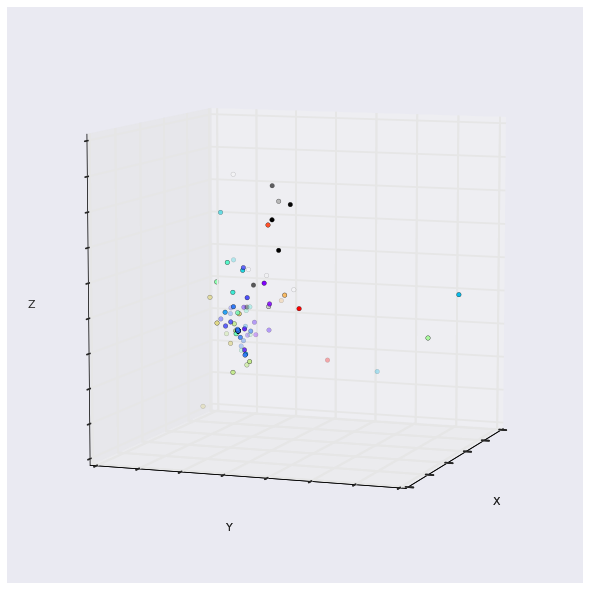

In [29]:
plot_cluster_data(training_data, models[5])

![](https://farm2.staticflickr.com/1604/24934700445_833f0a5649_t.jpg)

#### Question 11

<div class="alert alert-info">  

a) Write function `model_error_1` to calculate the sum of Squared Euclidean Distance from the Series objects to their clusters centroids.  

b) Comment the choice of the error function we use here. Is it a good error definition?

</div>

In [30]:
from scipy.spatial.distance import cdist

# calculate the Euclidean distance
# from each time series to its cluster center
# and sum all distances
def model_error_1(data, model):
    error = data.map(lambda x: cdist([model.centers[model.predict(x)]], np.array([x]), 'euclidean')).sum()
    return error[0]


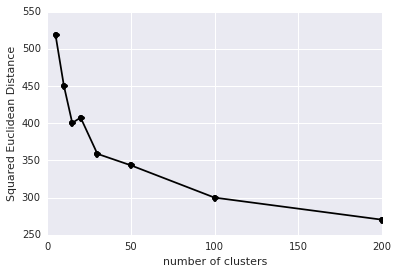

In [31]:
errors = [model_error_1(training_data, model) for model in models]
plt.plot(ks,errors,'k-o')
plt.xlabel('number of clusters')
plt.ylabel('Squared Euclidean Distance')
plt.show()

<div class="alert alert-warning">

This error function shows that as more number of clusters we create as less sum of Squared Euclidean Distance of all points for each cluster.. and it's obvious. It doesn't provide information about chosing the correct number of clusters.

</div>

![](https://farm2.staticflickr.com/1604/24934700445_833f0a5649_t.jpg)

#### Question 12
<div class="alert alert-info">

a) Write function `model_error_2` to calculate the total of similarity of `Series` objects based on how well they match the cluster they belong to, and then calculate the error by inverse the total similarity.  

b) Similarly to the previous question, comment the choice of the similarity function.  

</div>

In [32]:
# calculate the total of similarity of the model on timeseries objects
# and calculate the error by inverse the total similarity

# Estimate similarity between a data point and the cluster it belongs to.
def similarity(centers, p):
    if np.std(p) == 0:
        return 0
    return np.corrcoef(centers[np.argmin(cdist(centers, np.array([p])))], p)[0, 1]

                               
def model_error_2(data, model):
    #error = 1. / data.map(lambda x: similarity([model.centers[model.predict(x)] for model in models], x)).sum()
    error = 1. / data.map(lambda x: similarity(model.centers, x)).sum()
    return error


errors = [model_error_2(training_data, model) for model in models]
#print(error)

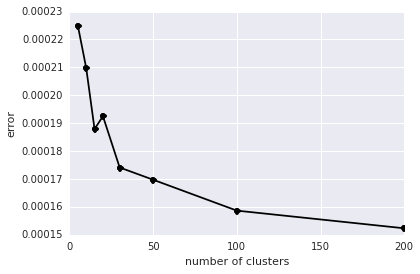

In [33]:
plt.plot(ks,errors,'k-o')
plt.xlabel('number of clusters')
plt.ylabel('error')
plt.show()

<div class="alert alert-warning">
The bigger the value of similarity, the closer a data point to the center of its cluster. That's why we take the inverse of sum of similarities.
</div>

![](https://farm2.staticflickr.com/1604/24934700445_833f0a5649_t.jpg)

#### Question 13
<div class="alert alert-info">

Plot the error of the models along with the different values of K in term of different error metrics above. From the figure, in your opinion, what is the best value for `K` ? Why ?

</div>

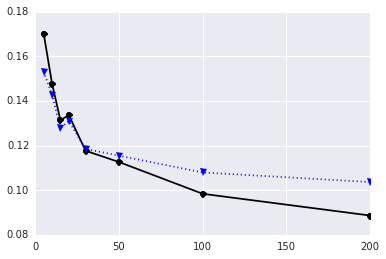

In [34]:

def testAndPlotTheResult(data, models):
    # compute the error metrics for the different resulting clusterings
    
    # errors of models when using function Sum Square Distance Error
    errors_1 = np.asarray([model_error_1(data, model) for model in models])
    
    # error of models when using similarity
    errors_2 = np.asarray([model_error_2(data, model) for model in models])

    # plot the errors with each value of K
    plt.plot(
        ks, errors_1 / errors_1.sum(), 'k-o',
        ks, errors_2 / errors_2.sum(), 'b:v')
    plt.show()
    
testAndPlotTheResult(training_data, models)


<div class="alert alert-warning">

From the figure above, we can see that from k = 30, the graph descreases more slightly than before for both error measurements. Therefore, k = 30 is might be a good value.
</div>

Determining the optimal $k$ is particularly troublesome for the $k$-Means algorithm because error measures based on distance decrease monotonically as $k$ increases. This arises because when $k$ is increased, each cluster is decomposed into more and more clusters, such that each point becomes closer to its cluster mean. In fact, in the extreme case where $k=N$, each point will be assigned to its own cluster, and all distances are reduced to nil. Cross-validation or using holdout data is also unlikely to be particularly effective in this case.<br>

To this end, it is often worth assessing a model by measuring its impact on the overall aim of carrying out the clustering. For example, if we are carrying out $k$-means for grouping customers having similar taste and purchase history with the ultimate intent of making recommendations to customers, our objective function should measure how effective the recommendations are (perhaps using holdout data). An appealing aspect of using such a metric is that it is no longer guaranteed to behave monotonically with respect to $k$. We shall investigate this further in Question 20.

![](https://farm2.staticflickr.com/1604/24934700445_833f0a5649_t.jpg)

#### Question 14
<div class="alert alert-info">

Plot the centroids of the best model. Do you think that the result is good ?

</div>

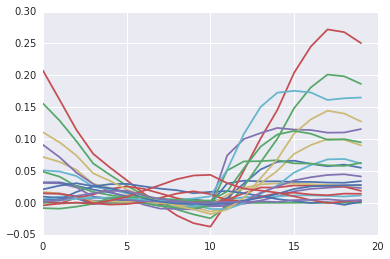

In [35]:

# plot the best performing model
bestModel = models[4]
plt.plot(np.array(bestModel.centers).T)
plt.show()


### e. Visualizing the result
We can also plot an image of labels of neurons, such that we can visualize the group of each neuron.

![](https://farm2.staticflickr.com/1604/24934700445_833f0a5649_t.jpg)

#### Question 15

<div class="alert alert-info">

Complete the source code below to visualize the result of clustering.

</div>

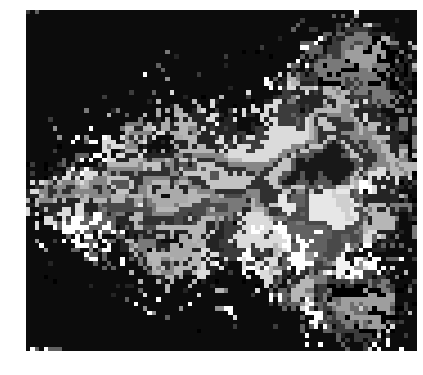

In [36]:

# predict the nearest cluster id for each voxel in Series
labels = bestModel.predict(training_data)

# collect data to the driver
imgLabels = np.array(labels.collect()).reshape(2,76,87)

# consider the voxel of the first layers
draw_image(imgLabels[0,:,:])


With the default color scheme, this figure is quite difficult to understand and to distinguish the groups according to their similar colors. So, we should have a smater color selection. The fact is, when we do clustering, it is often the case that some centers are more similar to one another, and it can be easier to interpret the results if the colors are choosen based on these relative similarities. The method `optimize` tries to find a set of colors such that similaries among colors match similarities among an input array (in this case, the cluster centers). The optimization is non-unique, so you can run multiple times to generate different color schemes.

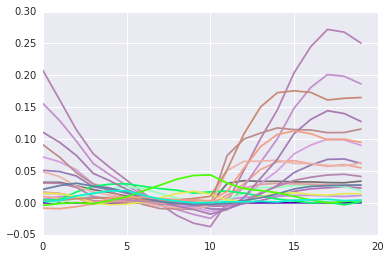

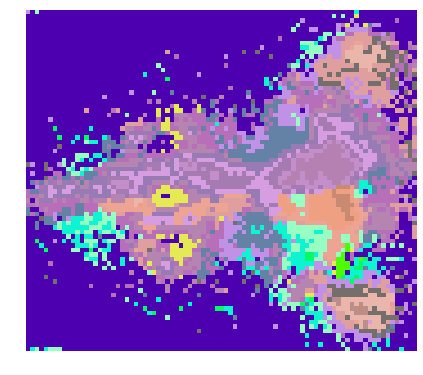

In [37]:
from numpy import arctan2, sqrt, pi, abs, dstack, clip, transpose, inf, \
    random, zeros, ones, asarray, corrcoef, allclose, maximum, add, multiply, \
    nan_to_num, copy, ndarray, around, ceil, rollaxis

# these functions below are inspired mainly from Thunder-Project source code, v.0.6
# url: https://raw.githubusercontent.com/thunder-project/thunder/branch-0.6/thunder/viz/colorize.py

# Optimal colors based on array data similarity.
def optimize_color(mat):
        mat = np.asarray(mat)

        if mat.ndim < 2:
            raise Exception('Input array must be two-dimensional')

        nclrs = mat.shape[0]

        from scipy.spatial.distance import pdist, squareform
        from scipy.optimize import minimize

        distMat = squareform(pdist(mat, metric='cosine')).flatten()

        optFunc = lambda x: 1 - np.corrcoef(distMat, squareform(pdist(x.reshape(nclrs, 3), 'cosine')).flatten())[0, 1]
        init = random.rand(nclrs*3)
        bounds = [(0, 1) for _ in range(0, nclrs * 3)]
        res = minimize(optFunc, init, bounds=bounds, method='L-BFGS-B')
        newClrs = res.x.reshape(nclrs, 3).tolist()

        from matplotlib.colors import ListedColormap

        newClrs = ListedColormap(newClrs, name='from_list')

        return newClrs

# Blend two images together using the specified operator.
def blend(img, mask, op=add):
        if mask.ndim == 3:
            for i in range(0, 3):
                img[:, :, :, i] = op(img[:, :, :, i], mask)
        else:
            for i in range(0, 3):
                img[:, :, i] = op(img[:, :, i], mask)
        return img

def _prepareMask(mask):
        mask = asarray(mask)
        mask = clip(mask, 0, inf)

        return mask / mask.max()
    
# Colorize numerical image data.
def transform(cmap, img, mask=None, mixing=1.0):
        from matplotlib.cm import get_cmap
        from matplotlib.colors import ListedColormap, LinearSegmentedColormap, hsv_to_rgb, Normalize

        img = asarray(img)
        dims = img.shape

        if cmap not in ['polar', 'angle']:

            if cmap in ['rgb', 'hv', 'hsv', 'indexed']:
                img = copy(img)
                for i, im in enumerate(img):
                    norm = Normalize(vmin=None, vmax=None, clip=True)
                    img[i] = norm(im)

            if isinstance(cmap, ListedColormap) or isinstance(cmap, str):
                norm = Normalize(vmin=None, vmax=None, clip=True)
                img = norm(copy(img))

        if mask is not None:
            mask = _prepareMask(mask)

        if isinstance(cmap, ListedColormap):
            if img.ndim == 3:
                out = cmap(img)
                out = out[:, :, :, 0:3]
            if img.ndim == 2:
                out = cmap(img)
                out = out[:, :, 0:3]
        else:
            raise Exception('Colorization method not understood')

        out = clip(out, 0, 1)

        if mask is not None:
            out = blend(out, mask, multiply)

        return clip(out, 0, 1)


# generate the better color scheme
newClrs = optimize_color(bestModel.centers)
plt.gca().set_color_cycle(newClrs.colors)
plt.plot(np.array(bestModel.centers).T);

# draw image with the new color scheme
brainmap = transform(newClrs, imgLabels[0,:,:])
draw_image(brainmap)


### f. Improving the result by removing noise
One problem with what we've done so far is that clustering was performed on all time-series without data pre-processing. Many of  time-series objects were purely noise (e.g. those outside the brain), and some of the resulting clusters capture these noise signals. A simple trick is to perform clustering after subselecting pixels based on the standard deviation of their time series. First, let's look at a map of the standard deviation, to find a reasonable threshold that preserves most of the relavant signal, but ignores the noise.

![](https://farm2.staticflickr.com/1604/24934700445_833f0a5649_t.jpg)

#### Question 16

<div class="alert alert-info">

Try with different threshold of standard deviation to filter the noise. What is the "best value" that preserves most of the relavant signal, but ignores the noise ? Why ?

</div>

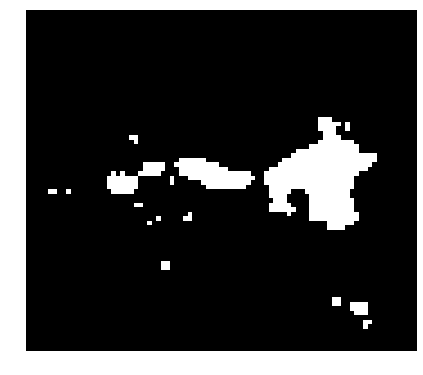

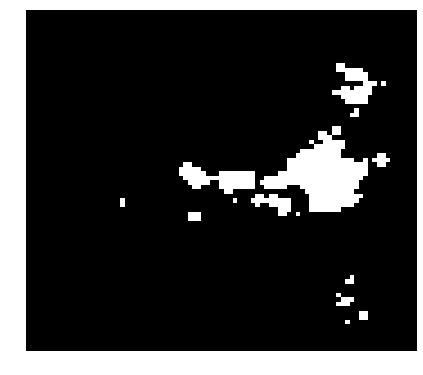

In [38]:

# calculate the standard deviation of each voxel 
# then collect to the driver
stdMap = data.map(lambda x: np.std(x)).toarray()

# here we should try with many different values of threshold 
# and choosing the best one
# visualize the map of the standard deviation after filtering
threshold = 0.04
draw_image(stdMap[0,:,:] > threshold)
draw_image(stdMap[1,:,:] > threshold)

<div class="alert alert-warning">
The best value of threshold can be determined based on  whether it can remove the part of the image not belong to the brain or not.<br/>
After trying several threshold values, we choose threshold = 0.04. 

</div>

![](https://farm2.staticflickr.com/1604/24934700445_833f0a5649_t.jpg)

#### Question 17

<div class="alert alert-info">

Filter your data such that we only keep the voxels that have the standard deviation bigger than the threshold in question 16.

</div>

In [39]:

####!@SOLUTION@!####
from numpy import std
threshold = 0.04
# remove series object that has the standard deviation bigger than a threshold
filtered = data.filter(lambda x: x.std() >= threshold).cache()
print(filtered.shape)


(876, 20)


![](https://farm2.staticflickr.com/1604/24934700445_833f0a5649_t.jpg)

#### Question 18

<div class="alert alert-info">

Re-train and choose the best models with different values of `K` on the new data.

</div>

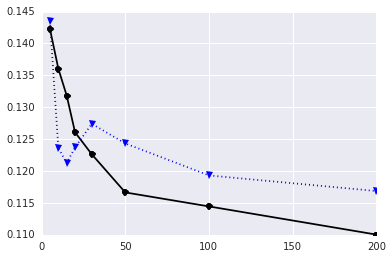

In [40]:
filtered_rdd = filtered.tordd().map(lambda x: x[1]).cache()
models = buildModels(filtered_rdd)
testAndPlotTheResult(training_data, models)


<div class="alert alert-warning">
According to the obtained graph, the number of cluster k = 30 is still a resonable one. If k &lt; 30, the behavior of errors is not stable, but after it's more or less stable or decrease slightly.
</div>

![](https://farm2.staticflickr.com/1604/24934700445_833f0a5649_t.jpg)

#### Question 19
<div class="alert alert-info">

a) Plot the centroids of the best model with a smart color selection.  

b) Plot the result of the clustering algorithm by a color map of voxels.  

c) Comment about your figures.  
</div>

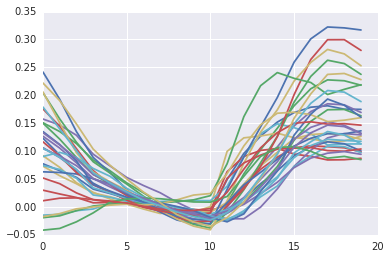

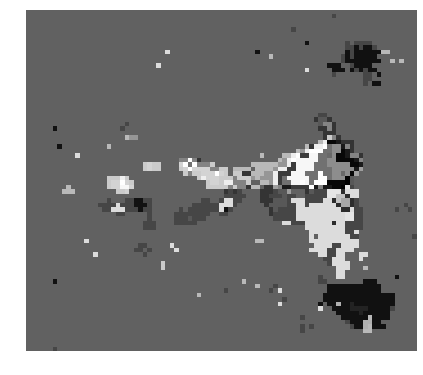

In [41]:
bestModel = models[4]
newClrs = bestModel.centers
plt.plot(np.array(newClrs).T)
plt.show()

# predict the nearest cluster id for each voxel in Series
labels = training_data.map(lambda serie: bestModel.predict(serie)).collect()

# collect data to the driver
imgLabels = np.array(labels).reshape(2, 76, 87)
#imgLabels = labels....
#...
#...
draw_image(imgLabels[0,:,:])

Apply color map transformation for cluster id

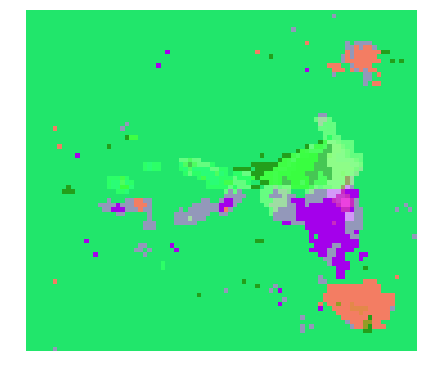

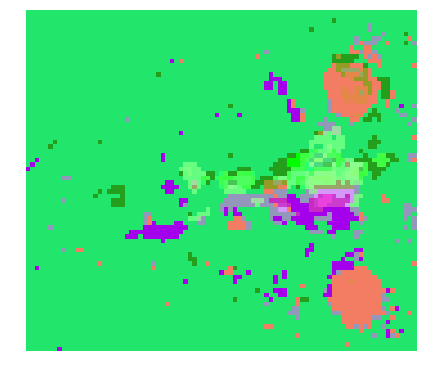

In [42]:
# generate the better color scheme
newClrs = optimize_color(bestModel.centers)
# draw image with the new color scheme
brainmap = transform(newClrs, imgLabels)
draw_image(brainmap[0,:,:])
draw_image(brainmap[1,:,:])

<div class="alert alert-warning">
According to the figure above, we can see that we still have some noises. The figure is not actually intuitive.
</div>

### g. Improve the visualization by adding similarity
These maps are slightly odd because pixels that did not survive our threshold still end up colored as something. A useful trick is masking pixels based on how well they match the cluster they belong to. We can compute this using the `similarity` method of `KMeansModel`.

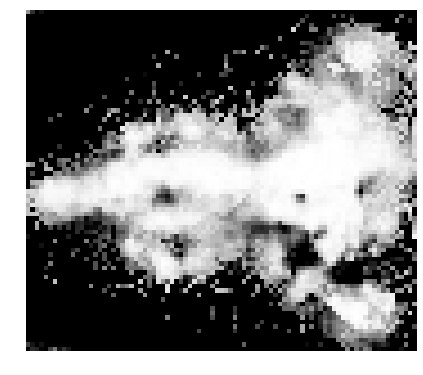

In [43]:
sim = data.map(lambda x: similarity(bestModel.centers, x))

imgSim = sim.toarray()

# draw the mask
draw_image(imgSim[0,:,:], cmap='gray', clim=(0,1))

And, it can be used as a linear mask on the colorization output

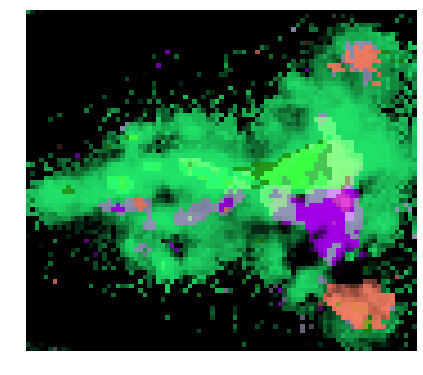

In [44]:
brainmap = transform(newClrs, imgLabels[0,:,:], mask=imgSim[0,:,:])
draw_image(brainmap)

![](https://farm2.staticflickr.com/1604/24934700445_833f0a5649_t.jpg)

#### Question 20

<div class="alert alert-info">

Since in the usecase we build and test the model from the same data, it can lead to overfitting problems. To avoid that, we can divide the data into training set and testing set. Note that each neuron occurs only one time in the data. So, we can not divide the data by dividing the neurons. Instead, we can divide the states of neurons into two different sets. Let's try with this approach and show the result.

</div>

In [45]:
# split train and test
train_data = data[:,:,:,:10].tordd().map(lambda x: x[1]).cache()
test_data = data[:,:,:,10:].tordd().map(lambda x: x[1]).cache()

In [46]:
# building model
models = buildModels(train_data)

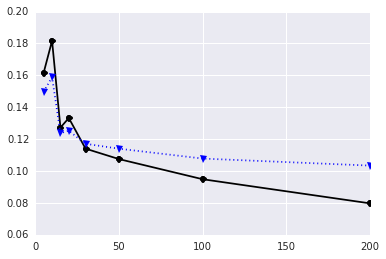

In [47]:
# test and plot the result for training data
testAndPlotTheResult(train_data, models)

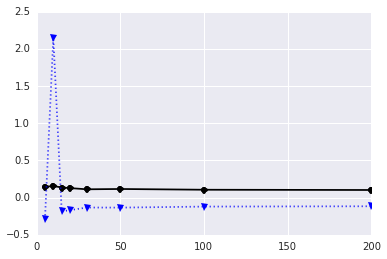

In [48]:
# test and plot the result for test data
testAndPlotTheResult(test_data, models)

<div class="alert alert-warning">
We didn't obtain the reasonable result because the splitting of the data is not correct. The neurons don't have any similar patterns in train and test data, the time period is too short. 
</div>

![](https://farm2.staticflickr.com/1604/24934700445_833f0a5649_t.jpg)

#### Question 21

<div class="alert alert-info">

Is using K-Means the best choice for a clustering algorithm? Comment the choice and suggest alternatives. For example, look at [Mixture Models](https://en.wikipedia.org/wiki/Mixture_model) and, if you have time, propose an alternative clustering technique. 

</div>

<div class="label label-danger">NOTE</div> Mixture models will be covered in the ASI course in greater detail.

To avoid the problem when training data, we filter all the points having std smaller than 0.04

In [49]:
from pyspark.mllib.clustering import GaussianMixture, GaussianMixtureModel


# declare the possible values of K
ks = [5, 10, 15, 20, 30, 50]

# convert series data to rdd of values
new_training_data = data.tordd().map(lambda x: x[1]).filter(lambda x: x.std() > 0.04).cache()

models_mixture = [GaussianMixture.train(new_training_data, k) for k in ks]

In [ ]:
models_mixture[0].predict(test_data).collect()

<div class="alert alert-warning">
We didn't succeed to run the predictions on the clusters, so we used following code to make predictions for the gaussian mixture model with 30 clusters and plotted obtained results.
</div>

In [171]:
d = data.toarray().reshape((2*76*87,20))
labels = []
for i in range(2*76*87):
    labels.append(models_mixture[4].predict(d[i,:]))

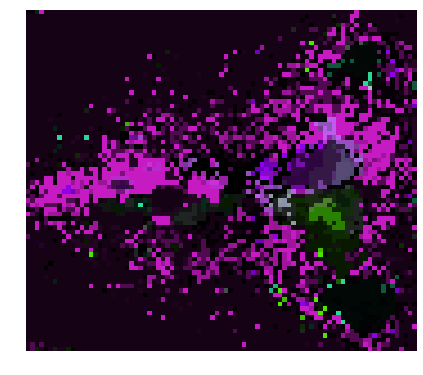

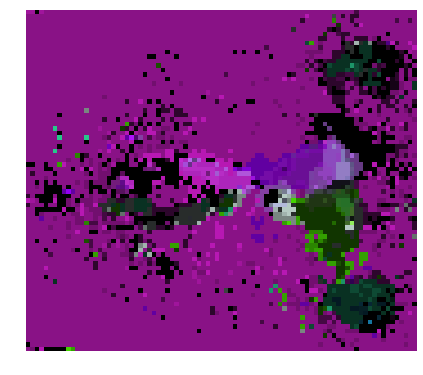

In [172]:
ls = np.array(labels).reshape((2,76,87))
brainmap1 = transform(newClrs, imgLabels[0,:,:], mask=ls[0,:,:])
draw_image(brainmap1)
brainmap2 = transform(newClrs, imgLabels[0,:,:], mask=ls[1,:,:])
draw_image(brainmap)

# 4. Summary
We studied Thunder and its important methods to work with images, such as `Image`, `Series` and how to apply them to a use case. In the use case, we used the K-Means algorithm to cluster the neurons without prior knowledge of what a good choice of K could be. Subsequently, we introduced some techniques for improving the initially obtained results, such as removing noise and considering similarity.

# References
Some of the examples in this notebook are inspired from the [documentation of Thunder](http://docs.thunder-project.org/).